# Кластеризация предложений

# Библиотеки

In [19]:
#import json
import os
#from google.colab import drive
from tqdm import tqdm
import pickle
from collections import Counter
import time

import pandas as pd

import numpy as np
#import scipy
from scipy import spatial

import torch
from sentence_transformers import SentenceTransformer, util
#from sklearn.metrics.pairwise import cosine_similarity
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS

import matplotlib.pyplot as plt
import seaborn as sns

# Функции

выделение кластера

In [20]:
def community_detection(embeddings, threshold=0.75, min_community_size=100, init_max_size=1000):
    """
    Function for Fast Community Detection
    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.pytorch_cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

def make_clusters_print(df, sentences='body', embeddings='embedding'):
    corpus_sentences = list(df[sentences])
    corpus_embeddings = list(df[embeddings])

    print("Start clustering")
    start_time = time.time()

    #Two parameter to tune:
    #min_cluster_size: Only consider cluster that have at least 25 elements (30 similar sentences)
    #threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
    clusters = community_detection(corpus_embeddings)

    print('Кол-во кластеров:', len(clusters))
    for cluster in range(len(clusters)):
        print(f'Кол-во элементов в кластере {cluster}:', len(clusters[cluster]))

    #Print all cluster / communities
    '''
    for i, cluster in enumerate(clusters):
        print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
        for sentence_id in cluster:
            print("\t", corpus_sentences[sentence_id])
    '''

    print("Clustering done after {:.2f} sec".format(time.time() - start_time))
    return clusters

def add_clusters_to_df(clusters,
                       df,
                       ):
    for i, cluster in enumerate(clusters):
        for row in cluster:
            try:
                df.iloc[row, -1] = i
            except:
                pass

отрисовка графика и понижение размерности

In [21]:
def plot_2d_pca_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    '''
    reducing to 2d with PCA
    '''
    pca = PCA(n_components = 2)
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = pca.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()


def plot_2d_tsne_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    '''
    reducing to 2d with TSNE
    '''
    tsne = TSNE(n_components = 2)
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = tsne.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()
    

def plot_2d_umap_representation_of_sentence(
    data, 
    embedding="embedding",
    label = "label",
    alpha=0.4
):
    '''
    reducing to 2d with UMAP
    '''
    reducer = umap.UMAP(n_neighbors=3, min_dist=0, metric='cosine')
    
    sentence_vectors = list(data[embedding])
    sentence_plus_coordinates = pd.DataFrame(sentence_vectors)
    
    labels = data[label].reset_index(drop=True)
    
    coordinates_2d = reducer.fit_transform(sentence_plus_coordinates)
    coordinates_2d = pd.DataFrame(coordinates_2d, columns=['x', 'y'])
    coordinates_2d = pd.concat([coordinates_2d, labels], axis=1)
            
    plt.figure(figsize = (15,10))
    p1=sns.scatterplot(data=coordinates_2d, x='x', y='y', hue=label, alpha=alpha)
    
    x = coordinates_2d['x']
    y = coordinates_2d['y']
    
    plt.show()

# Загружаем данные

Проверям папку

In [22]:
comments_dir = r"\Users\Home\Documents\Data Science\comptech\weights\sbert"
os.listdir(comments_dir)[:5]

['df_test.pickle', 'df_train.pickle']

In [23]:
%%time

with open(os.path.join(comments_dir, 'df_train.pickle'), mode='rb') as pandas_file:
    train_df = pickle.load(pandas_file)

Wall time: 1.86 s


соркатим выборку до 50 к

In [26]:
train_df = train_df.sample(50000)

# Кластеризация fast_clustering

In [28]:
train_df["label"] = np.nan
print(train_df.shape)
train_df.head(2)

(50000, 9)


,author,body,created_utc,link_id,parent_id,score,who,embedding,label
90193,Fo1klor3,do not you know? In their eyes Tr*mp can do no...,1607065606,t3_k6a28a,t1_geklp46,1,1.0,"[0.29243064, -0.15775524, 0.18305223, 0.055544...",NaN
3337,holyshithead,they are always willing to sacrifice other peo...,1605864056,t3_jxhp3m,t1_gcxbsgx,6,0.0,"[-0.23175214, 0.39164, 0.30778596, 0.39725447,...",NaN


In [29]:
%%time
add_clusters_to_df(make_clusters_print(train_df), train_df)
comments_df.sample(2)

Start clustering
Кол-во кластеров: 6
Кол-во элементов в кластере 0: 11170
Кол-во элементов в кластере 1: 858
Кол-во элементов в кластере 2: 576
Кол-во элементов в кластере 3: 298
Кол-во элементов в кластере 4: 174
Кол-во элементов в кластере 5: 116
Clustering done after 126.57 sec
Wall time: 2min 12s


,author,body,created_utc,link_id,parent_id,score,part,embedding
426821,apleaux,God help us. Please not Tucker. Tucker is a so...,1604807137,t3_jpy7vf,t1_gbjqt3l,1,1.0,"[0.62957096, -0.546692, 0.8798615, 0.83201504,..."
5299,cc16927,That would be 42 million dollars a quarter. Th...,1581362601,t3_f1syhk,t1_fh8l3ob,1,1.0,"[0.37295833, 0.9081277, 0.9062299, -0.49515894..."


Cохраняем полученную таблицу с кластерами и ембедингами в файл

In [31]:
with open(r"\Users\Home\Documents\Data Science\comptech\clusters\df_train.pickle", 'wb') as f:
    pickle.dump(train_df, f)

Смотррим на результаты распределения партий внутри кластеров

In [36]:
for cluster in range(5):
    print(f'Рапределение байден трамп Cluster {cluster}:', train_df[train_df['label'] == cluster]['who'].value_counts(), '\n')

Рапределение байден трамп Cluster 0: 1.0    5917
0.0    5253
Name: who, dtype: int64 

Рапределение байден трамп Cluster 1: 0.0    571
1.0    287
Name: who, dtype: int64 

Рапределение байден трамп Cluster 2: 1.0    375
0.0    201
Name: who, dtype: int64 

Рапределение байден трамп Cluster 3: 0.0    192
1.0    106
Name: who, dtype: int64 

Рапределение байден трамп Cluster 4: 0.0    103
1.0     71
Name: who, dtype: int64 



In [39]:
list(train_df[train_df['label'] == 0]['body'])[:10]

['I have been telling people for a year now — Iowa is still very much a swing state. It was incredibly naive to write us off as a reliably-R state post-2016. Too many people saw Trump’s 9pt margin of victory in Iowa against Clinton, but did not see that he barely cracked 50% to do so. I am going to, the 2016 results in Iowa were far more an “anti-Clinton” vote not a “pro-Trump” vote.',
 'Fuck the liberals, first and foremost. Those fucking skeezy bastards trying to give money to bullshit. And FUCK the republicans who supported this bullshit too. We need a new party. I am done with the GOP.',
 '" "Power" is both a singular and plural noun, despite the word "powers" existing" \\- And I was using it in the singular sense. I suppose I should have said... " it is surreal that the US gave it is presidents a power that a King has" ...just in case someone wrongly asserted that the power of pardon was not in the constitution and had to resort to pedantry when proved wrong. " Pardoning is a powe

In [40]:
list(train_df[train_df['label'] == 1]['body'])[:10]

['What the fuck are you talking about?',
 'You guys are really dumb. Oof ow ouchie did i violate your safe space?',
 'id call xir an idiot while walking by',
 'Yeah kind of a bad move. Makes Biden voters look bad.',
 'You people are crazy and seditious.',
 'come on, you missed out on the opportunity to use "A new hope"? :P',
 'Who sent this man. he is Biden’s worse nightmare!',
 'How do you function with such a shitty brain?',
 'In other words, you have jack shit.',
 'Pfft what would *she* know? it is not like she lea...oh']

In [41]:
list(train_df[train_df['label'] == 2]['body'])[:10]

['That feels true to me so I will believe it.',
 'brave wonderful souls. god bless you both. go joe!!!',
 'I am inclined to think he would be pretty good too .',
 'Well done! Thank you for your vote!',
 'Lol god, I love that man.',
 'I say I do. that is a good jest, me boyo. I like this.',
 'GN bud, we can do this :)',
 'No problem. I am doing my part!',
 'I like the way you think ',
 'This means a lot to me.']

In [42]:
list(train_df[train_df['label'] == 3]['body'])[:10]

['Of course it is not politically motivated. can not have any facts supporting Trump’s positions.',
 'Just like he never met any of the people he fired',
 'Hmm, nah I would not shake Commie Sanders hand.',
 'he is not the one that mentioned rebellion dude...',
 'And not one word from the American press about him sexually assaulting her.',
 'Which has not happened, so they are still not subject to the 1st Amendment',
 'You have not provided anything but propaganda and lies. Trolling and arguing in bad faith are against the rules of this sub.',
 'Amy Klobuchar - “No witnesses and no evidence = no justice” just do not look at what Adam Schiff has done',
 "No, I did not see a CNN staffer's ass there at any point.",
 'Well one thing we do know is that it was never taught to AOC.']

### понижение размерности PCA

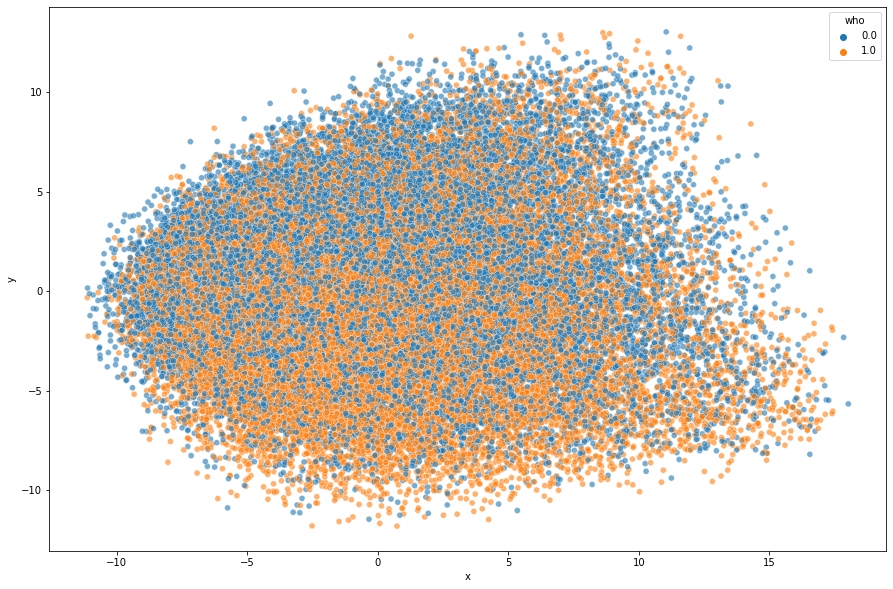

Wall time: 18 s


In [43]:
%%time
plot_2d_pca_representation_of_sentence(train_df, alpha=0.6, label='who')

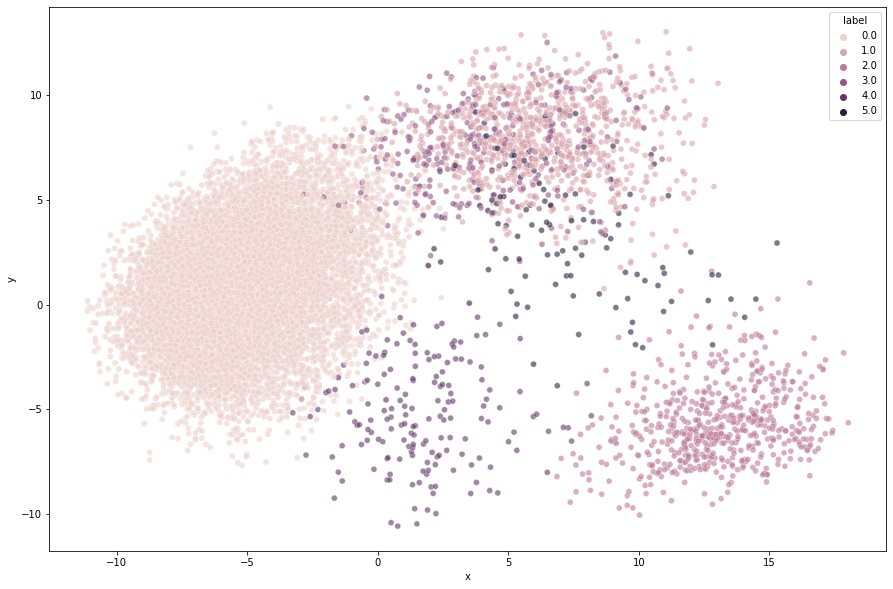

Wall time: 16.8 s


In [44]:
%%time
plot_2d_pca_representation_of_sentence(train_df, alpha=0.6)

### Понижение размерности TSNE

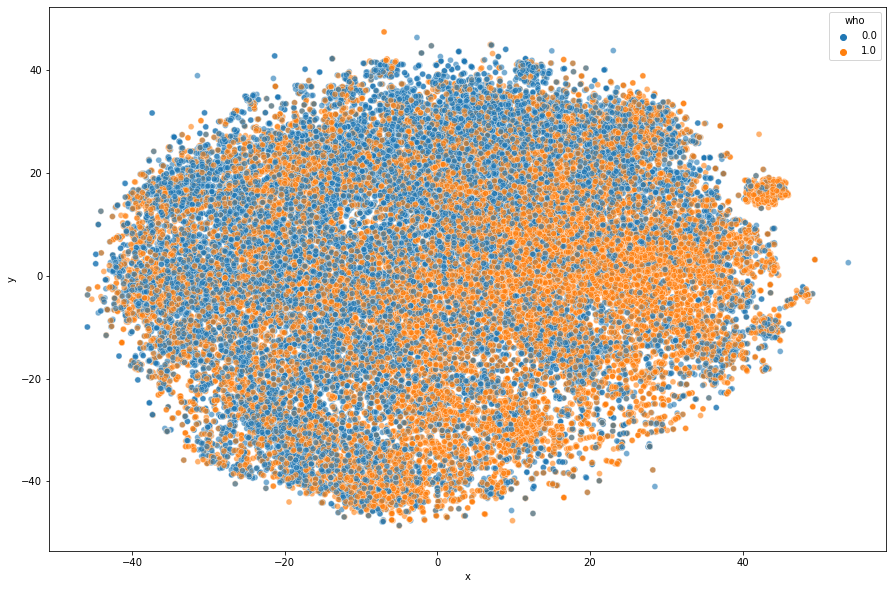

Wall time: 1h 10min 2s


In [46]:
%%time
plot_2d_tsne_representation_of_sentence(train_df, alpha=0.6, label='who')

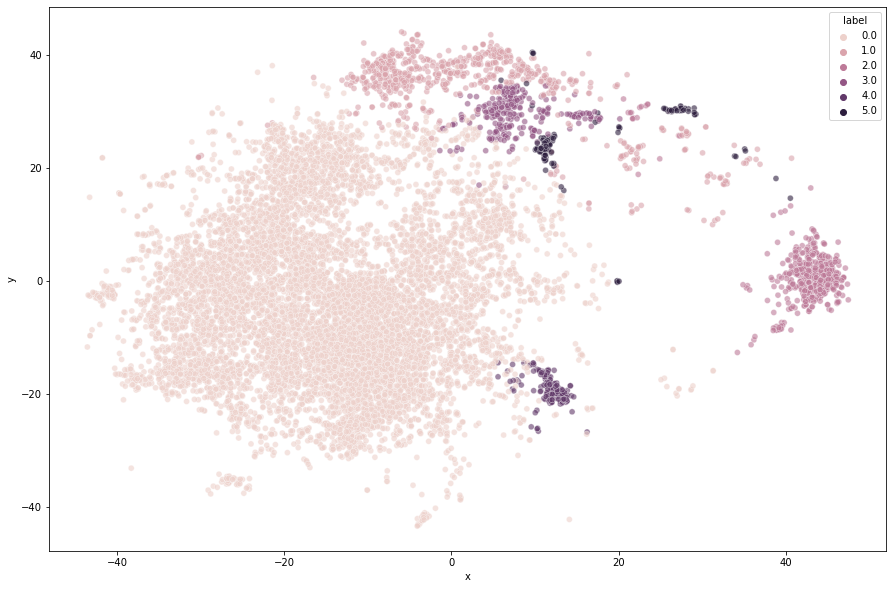

Wall time: 1h 9min 42s


In [47]:
%%time
plot_2d_tsne_representation_of_sentence(train_df, alpha=0.6)

### Понижение размерности umap

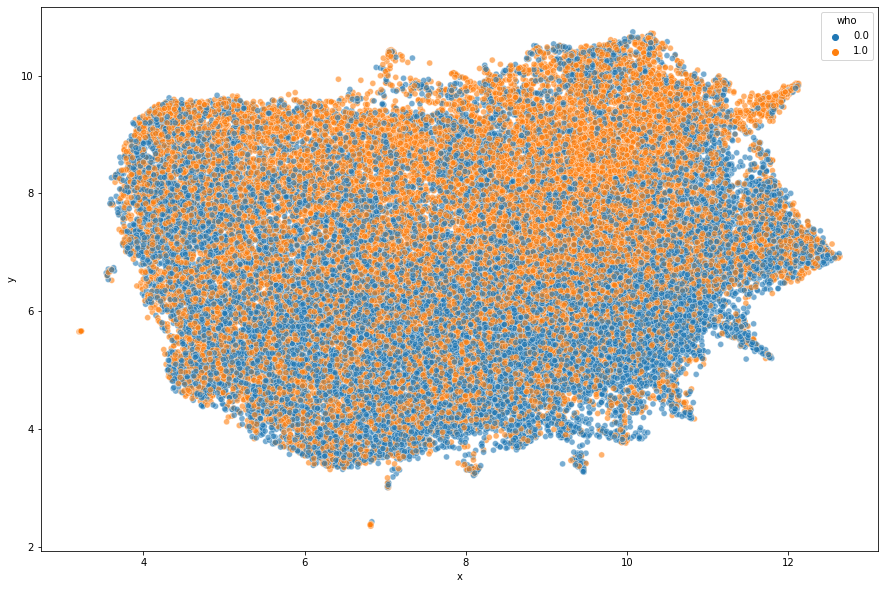

Wall time: 34.8 s


In [49]:
%%time
plot_2d_umap_representation_of_sentence(train_df, alpha=0.6, label='who')

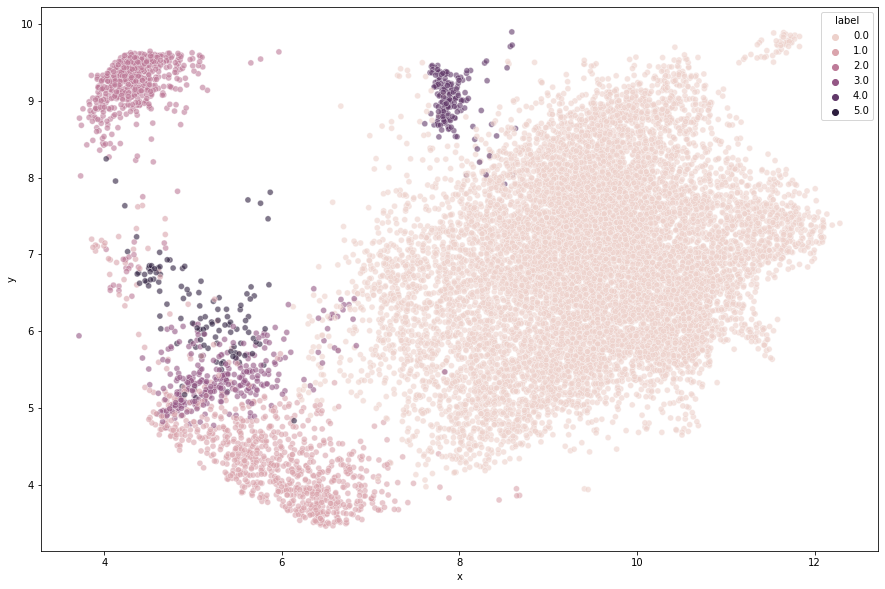

Wall time: 47.9 s


In [48]:
%%time
plot_2d_umap_representation_of_sentence(train_df, alpha=0.6)